In [769]:
import os
current_dir = os.getcwd()
root_dir = current_dir.split('FAST')[0] + 'FAST'
os.chdir(root_dir)
import sys
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2
from mmcv import Config
from dataset import build_data_loader
from models import build_model
from models.utils import fuse_module, rep_model_convert
from utils import ResultFormat, AverageMeter
import json
import random
from mmcv.cnn import get_model_complexity_info
from tqdm import tqdm
from PIL import Image

In [770]:
dataset = 'ctw'
config = 'config/fast/ctw/fast_base_fsnet_ema_ctw_512_finetune_mixnet.py'
model_path = 'pretrained/checkpoint_4ep.pth.tar'
img_index = 152

ema = True
print_model = False
is_report_speed = False
worker = 4
thickness = {'msra': 12, 'ctw':4, 'tt':4, 'ic15': 4}
batch_size = 1
fine_map = False

In [771]:
# 定义一个钩子（Hook），用于提取卷积层的特征图
class FeatureExtractor():
    def __init__(self, model, target_layers):
        self.model = model
        self.target_layers = target_layers
        self.gradients = []

    def save_gradient(self, grad):
        self.gradients.append(grad)

    def __call__(self, x):
        outputs = []
        self.gradients = []
        for name, module in self.model._modules.items():
            x = module(x)
            if name in self.target_layers:
                x.register_hook(self.save_gradient)
                outputs += [x]
        return outputs, x

In [772]:
# 图片预处理
# 加载图像并进行必要的预处理
def preprocess_image(img_path):
    preprocess = transforms.Compose([
        # transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img = Image.open(img_path).convert('RGB')
    img = preprocess(img).unsqueeze(0)
    return img


# 可视化特征图的函数
def show_feature_maps(feature_maps, num_columns=6):
    num_features = feature_maps.shape[1]
    num_rows = num_features // num_columns + int(num_features % num_columns != 0)
    
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(num_columns*2, num_rows*2))
    for i in range(num_features):
        ax = axes[i // num_columns, i % num_columns]
        ax.imshow(feature_maps[0, i].detach().numpy(), cmap='jet')
        ax.axis('off')
    plt.show()
    
def get_image_list(dataset):
    if dataset == 'ctw':
        img_list = os.listdir("data/CTW1500/test/text_image")
        image_list = [os.path.join('data/CTW1500/test/text_image', img_list[i]) for i in range(len(img_list))]
    elif dataset == 'tt':
        img_list = os.listdir("data/total_text/Images/Test")
        image_list = [os.path.join('data/total_text/Images/Test', img_list[i]) for i in range(len(img_list))]
    elif dataset == 'msra':
        img_list = os.listdir("data/MSRA-TD500/test")
        img_list = [file for file in img_list if file.endswith((".jpg", ".JPG", ".png", "PNG"))]
        image_list = [os.path.join('data/MSRA-TD500/test', img_list[i]) for i in range(len(img_list))]
    elif dataset == 'ic15':
        img_list = os.listdir("data/ICDAR2015/Challenge4/ch4_test_images")
        image_list = [os.path.join('data/ICDAR2015/Challenge4/ch4_test_images', img_list[i]) for i in range(len(img_list))]
    return img_list, image_list

In [773]:
def test(test_loader, model, cfg):

    rf = ResultFormat(cfg.data.test.type, cfg.test_cfg.result_path)

    if is_report_speed:
        speed_meters = dict(
            backbone_time=AverageMeter(1000 // batch_size),
            neck_time=AverageMeter(1000 // batch_size),
            det_head_time=AverageMeter(1000 // batch_size),
            post_time=AverageMeter(1000 // batch_size),
            total_time=AverageMeter(1000 // batch_size)
        )
    results = dict()
    filename_list = []
    data = test_loader.dataset.prepare_test_data(img_index)
    # data = test_loader
    data['imgs'] = data['imgs'].unsqueeze(0)
    data['img_metas']['org_img_size'] = torch.tensor(data['img_metas']['org_img_size']).unsqueeze(0)
    data['img_metas']['img_size'] = torch.tensor(data['img_metas']['img_size']).unsqueeze(0)
    filename_list.append(data['img_metas']['filename'])
    data['img_metas']['filename'] = filename_list
    print("Testing image %s.png"% (data['img_metas']['filename'][0]))
    # prepare input
    data['imgs'] = data['imgs'].cuda(non_blocking=True)
    data.update(dict(cfg=cfg))
    # forward
    with torch.no_grad():
        outputs = model(**data)
    if is_report_speed:
        report_speed(model, data, speed_meters, batch_size)

    # save result
    image_name = data['img_metas']['filename'][0]

    rf.write_result(image_name, outputs['results'][0])
    results[image_name] = outputs['results'][0]
    print(results)

    if is_report_speed:
        results = json.dumps(results)
        print(results)
    return results

def report_speed(model, data, speed_meters, batch_size=1, times=10):
    for _ in range(times):
        total_time = 0
        outputs = model(**data)
        for key in outputs:
            if 'time' in key:
                speed_meters[key].update(outputs[key] / batch_size)
                total_time += outputs[key] / batch_size
        speed_meters['total_time'].update(total_time)
        for k, v in speed_meters.items():
            print('%s: %.4f' % (k, v.avg))
        print('FPS: %.1f' % (1.0 / speed_meters['total_time'].avg))

def model_structure(model):
    blank = ' '
    print('-' * 90)
    print('|' + ' ' * 11 + 'weight name' + ' ' * 10 + '|' \
          + ' ' * 15 + 'weight shape' + ' ' * 15 + '|' \
          + ' ' * 3 + 'number' + ' ' * 3 + '|')
    print('-' * 90)
    num_para = 0
    type_size = 1  ##如果是浮点数就是4

    for index, (key, w_variable) in enumerate(model.named_parameters()):
        if len(key) <= 30:
            key = key + (30 - len(key)) * blank
        shape = str(w_variable.shape)
        if len(shape) <= 40:
            shape = shape + (40 - len(shape)) * blank
        each_para = 1
        for k in w_variable.shape:
            each_para *= k
        num_para += each_para
        str_num = str(each_para)
        if len(str_num) <= 10:
            str_num = str_num + (10 - len(str_num)) * blank

        print('| {} | {} | {} |'.format(key, shape, str_num))
    print('-' * 90)
    print('The total number of parameters: ' + str(num_para))
    print('The parameters of Model {}: {:4f}M'.format(model._get_name(), num_para * type_size / 1000 / 1000))
    print('-' * 90)

In [774]:
cfg = Config.fromfile(config)

# model
model = build_model(cfg.model)
model = model.cuda()
# print(model)

# data loader
data_loader = build_data_loader(cfg.data.test)
test_loader = torch.utils.data.DataLoader(
    data_loader,
    batch_size=batch_size,
    shuffle=False,
    num_workers=worker,
    pin_memory=False
)

In [775]:
# 注册钩子
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook


Loading model and optimizer from checkpoint 'pretrained/checkpoint_4ep.pth.tar'


/root/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:3769: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Testing image 1153.png
{'1153': {'bboxes': [[235, 7, 235, 8, 234, 9, 202, 9, 202, 10, 201, 11, 191, 11, 191, 12, 190, 12, 183, 12, 183, 14, 183, 14, 174, 14, 174, 16, 174, 16, 165, 16, 165, 17, 164, 18, 159, 18, 159, 19, 159, 20, 154, 20, 154, 21, 153, 22, 147, 22, 147, 23, 146, 23, 139, 23, 139, 25, 139, 25, 136, 25, 136, 27, 135, 27, 132, 27, 132, 29, 131, 29, 128, 29, 128, 30, 128, 31, 123, 31, 123, 32, 122, 33, 119, 33, 119, 34, 119, 35, 113, 35, 113, 36, 113, 36, 108, 36, 108, 38, 107, 38, 104, 38, 104, 40, 104, 40, 102, 40, 102, 41, 102, 42, 95, 42, 95, 43, 95, 44, 91, 44, 91, 45, 91, 46, 88, 46, 88, 47, 87, 47, 86, 47, 86, 49, 85, 49, 84, 49, 84, 53, 84, 53, 82, 53, 82, 58, 84, 58, 84, 59, 84, 62, 85, 62, 86, 62, 86, 64, 87, 64, 88, 64, 88, 67, 89, 67, 90, 68, 90, 75, 91, 75, 91, 75, 91, 78, 93, 78, 93, 79, 93, 82, 95, 82, 95, 82, 95, 88, 96, 88, 97, 88, 97, 91, 98, 91, 99, 92, 99, 93, 100, 93, 101, 94, 101, 95, 109, 95, 109, 94, 110, 93, 111, 93, 111, 92, 112, 91, 115, 91, 115,

100%|██████████| 5/5 [00:00<00:00, 24.20it/s]


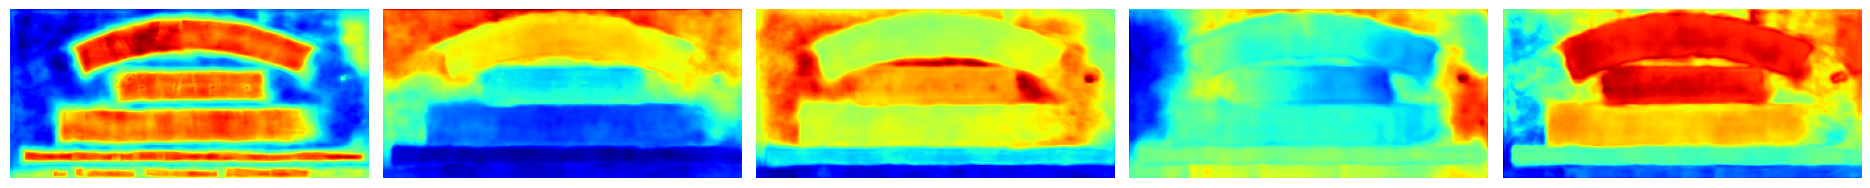

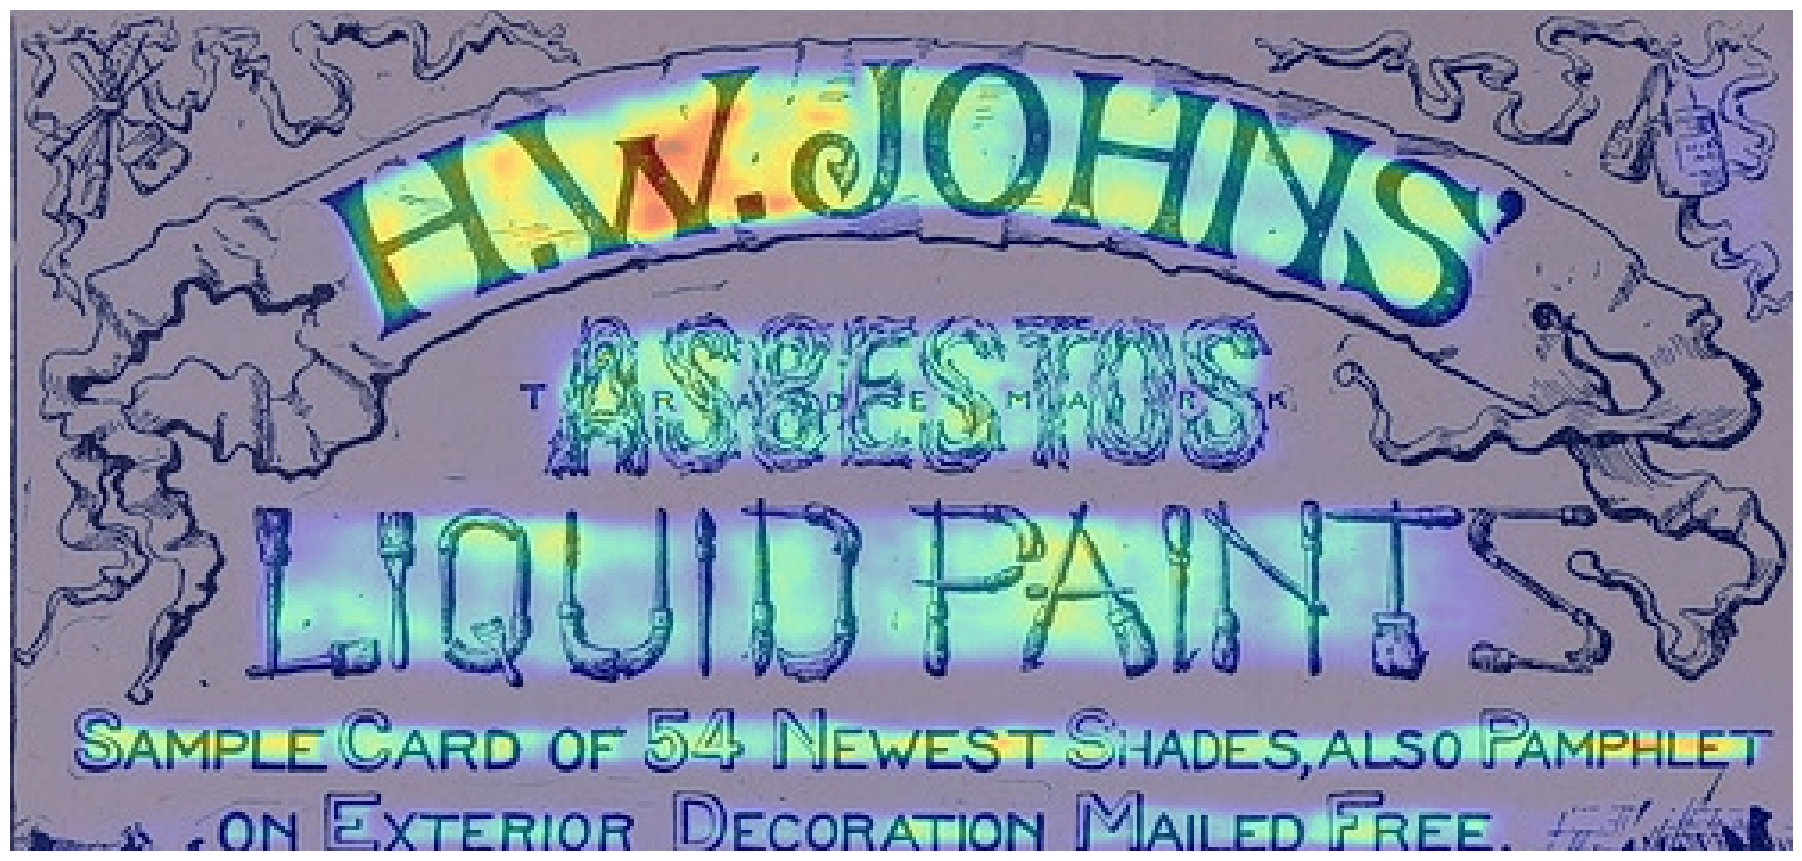

In [776]:
fine_map = False

if os.path.isfile(model_path):
    print("Loading model and optimizer from checkpoint '{}'".format(model_path))
    sys.stdout.flush()
    checkpoint = torch.load(model_path)
    
    if not ema:
        state_dict = checkpoint['state_dict']
    else:
        state_dict = checkpoint['ema']

    d = dict()
    for key, value in state_dict.items():
        tmp = key.replace("module.", "")
        d[tmp] = value
    model.load_state_dict(d)
else:
    print("No checkpoint found at '{}'".format(model_path))
    raise

model = rep_model_convert(model)

# fuse conv and bn
model = fuse_module(model)

if print_model:
    model_structure(model)

model.eval()

# 选择一个特定的层来提取特征图
layer_name = 'det_head'  # 假设我们提取最后的特征图
hook = getattr(model, layer_name).register_forward_hook(get_activation(layer_name))

result = test(test_loader, model, cfg)

# 移除钩子
hook.remove()
# 获取特征图数据
feature_maps = activation[layer_name].squeeze(0)

# 生成热力图
heatmaps = []
num_feature_maps = feature_maps.size(0)
plt.figure(figsize=(30, num_feature_maps // 2))
for i in tqdm(range(num_feature_maps)):
    
    cols = num_feature_maps // 8 if num_feature_maps % 8 == 0 else (num_feature_maps // 8) + 1
    ax = plt.subplot(cols, 8, i + 1)
    feature_maps_tmp = feature_maps[i].cpu().numpy()
    if fine_map:
        feature_maps_tmp = np.clip(feature_maps_tmp,0, 255)
    heatmaps.append(feature_maps_tmp)
    plt.imshow(feature_maps_tmp, cmap='jet')
    plt.axis('off')
plt.tight_layout()
plt.show()

_, image_list = get_image_list(dataset)
input_tensor = preprocess_image(image_list[img_index])

if fine_map:
    feature_map = heatmaps[0]
    # 归一化特征图
    feature_map = (feature_map - feature_map.min()) / (feature_map.max() - feature_map.min())
else:
    feature_map = feature_maps[0].cpu().numpy()
    # 归一化特征图
    feature_map = (feature_map - feature_map.min()) / (feature_map.max() - feature_map.min())
    # 应用Gamma变换来增强高亮区域
    # Gamma值小于1会增加图像亮度，而大于1会降低图像亮度
    gamma = 5
    feature_map = np.power(feature_map, gamma)


# 创建热力图
heatmap = plt.get_cmap('jet')(feature_map)[:, :, :3]  # 只取RGB通道
heatmap = np.uint8(255 * heatmap)  # 将热力图转换为RGB格式
heatmap = Image.fromarray(heatmap).resize((input_tensor.shape[3],input_tensor.shape[2]))  # 重设热力图大小以匹配原始图像
heatmap = np.array(heatmap) / 255

# 获取原始图像的数据

original_img = input_tensor.squeeze(0).permute(1, 2, 0)
original_img = original_img.cpu().numpy() * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
original_img = np.clip(original_img, 0, 1)

# 叠加热力图和原始图像
superimposed_img = heatmap * 0.4 + original_img * 0.6
plt.figure(figsize=(superimposed_img.shape[0]//10, superimposed_img.shape[1]//10))
plt.imshow(superimposed_img)
plt.axis('off')
plt.show()


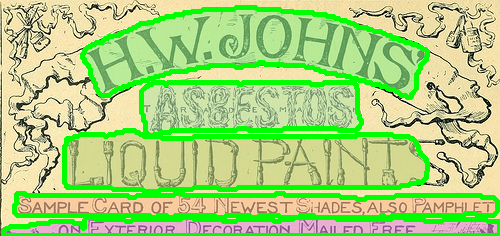

In [777]:
from PIL import Image

def draw(img, boxes):
    
    mask = np.zeros(img.shape, dtype=np.uint8)
    
    for box in boxes:
        rand_r = random.randint(100, 255)
        rand_g = random.randint(100, 255)
        rand_b = random.randint(100, 255)
        mask = cv2.fillPoly(mask, [box], color=(rand_r, rand_g, rand_b))
    
    img[mask!=0] = (0.6 * mask + 0.4 * img).astype(np.uint8)[mask!=0]
    
    for box in boxes:
        cv2.drawContours(img, [box], -1, (0, 255, 0), thickness[dataset])

    return img

img_list, image_list = get_image_list(dataset)
    
img = cv2.imread(image_list[img_index])
img = img[:, :, [2, 1, 0]]
pred = result[img_list[img_index].split('.')[0]]['bboxes']

if dataset == 'msra': # process predictions
    pred = np.array(pred)
    if pred.shape[0] > 0:
        pred = np.reshape(pred, (pred.shape[0], -1, 2)).astype('int32')
elif dataset == 'ctw':
    # pred = pred.tolist()
    for i in range(len(pred)):
        pred[i] = np.reshape(np.flipud(pred[i]), (-1, 2)).astype('int32')
elif dataset == 'tt':
    # pred = pred.tolist()
    for i in range(len(pred)):
        pred[i] = np.reshape(np.flipud(pred[i]), (-1, 2)).astype('int32')
elif dataset == 'ic15':
    # pred = pred.tolist()
    for i in range(len(pred)):
        pred[i] = np.reshape(pred[i], (-1, 2)).astype('int32')
        
img_n = img.copy()
if dataset != 'msra' and dataset != 'ic15':
    pred = [pred[i][:, [1, 0]] for i in range(len(pred))]
img_pred = draw(img_n, pred, ) # draw predictions on images
img = Image.fromarray(img_n)
img.show('v')